# Bayesian Blocks for Bump-Hunting (formal)

The goal of the Bayesian Blocks (BB) binning algorithm (http://arxiv.org/abs/1207.5578) is to choose optimal bin edges for a given histogram.  The optimality criterion is expressed by choosing bin edges such that the content within the bin edges is consistent with a uniform distribution, and thus any fluctuation in data values within two given bin edges is solely statistical in nature.  This binning method was initially developed for the astronomy community, in which signals appear as a uniform distribution on top of a noisy, constant background.  If the signal is statistically significant with respect to the background, then it should fall into its own bin in order to maximize a fitness metric, which is a function of the data and the binning.

However, when the nature of the signal and background change from the aforementioned distributions, one must be cautious when using the naive implementation of BB.  Typically when bump-hunting in particle physics, the signal appears as a Gaussian distribution, and the background is monotonically increasing or decreasing.  The naive BB algorithm may combine the increasing (decreasing) edge of the signal with the decreasing (increasing) edge of the background, and thus incorrectly identify the signal.

Instead, we will attempt to determine whether or not we should apply a finer binning to a signal region by examining the optimal binning for the background-only and signal-only cases.

## An $\mathrm{H}\gamma\gamma$ Simulation

We will generate a toy data and signal distribution to mimic a Higgs boson signal in the $p\rightarrow\gamma\gamma$ spectrum.  We will use Monte Carlo simulation generated in Delphis to represent both the decaying $m_{\gamma\gamma}$ spectrum and the Gaussian-like signal distribution, then define parametric functions that can be used to represent these distributions.

First, we will set up the necessary imports and function definitions:

In [1]:
from __future__ import division
import os
import functools
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pkl
from bb.tools.hist_tools_modified import hist
from bb.tools.bb_plotter import make_fit_plot, make_bb_plot
import hgg_comp as hgg_tools
import nllfitter.future_fitter as ff

%matplotlib inline
plt.rcParams['figure.figsize'] = (12,8)

Welcome to JupyROOT 6.08/02


We will now load the Monte Carlo data, and specify the background and signal ranges.  We want the background to range from $100 GeV<m_{\gamma\gamma}<180 GeV$ and the signal is selected such that it ranges from $118 GeV<m_{\gamma\gamma}<133 GeV$ with a peak at 125.5 GeV.  We will inject `n_sig` number of signal events, where `n_sig` is equal to $5\sqrt{n_{bg}}$ within the pre-defined signal region.

In [2]:
bb_dir      = os.path.join(os.path.dirname(hgg_tools.__file__), '../..')
hgg_bg      = pkl.load(open(bb_dir+'/files/hgg_bg.p', "rb"))
hgg_signal  = pkl.load(open(bb_dir+'/files/hgg_signal.p', "rb"))

n_sigma              = 5 #estimated significance of injected signal
hgg_bg_selection     = hgg_bg[(hgg_bg.Mgg > 100) & (hgg_bg.Mgg < 180)][0:10000].Mgg
n_bg_under_sig       = hgg_bg_selection[(118 < hgg_bg_selection) & (hgg_bg_selection < 133)].size
n_sig                = int(n_sigma*np.sqrt(n_bg_under_sig))
hgg_signal_selection = hgg_signal[(hgg_signal.Mgg >= 118) & (hgg_signal.Mgg <= 133)][0:n_sig].Mgg
data_bg              = hgg_bg_selection.values
data_sig             = hgg_signal_selection.values

xlimits = (100., 180.)
x       = np.linspace(xlimits[0], xlimits[1], 10000)
nbins   = 80 # for 2 GeV histogram binning
binning = (xlimits[1]-xlimits[0])/nbins

The background function will be fit with a 3rd order Legendre polynomial, and the signal will be fit with a Gaussian distribution.  These functional forms will be used to generate background and signal MC, which will then be evaluated with the BB algorithm.  This is done to allow for an easy comparison of statistical significance between the BB and unbinned fit methods without the introduction of additional uncertainty regarding the true underlying pdfs.

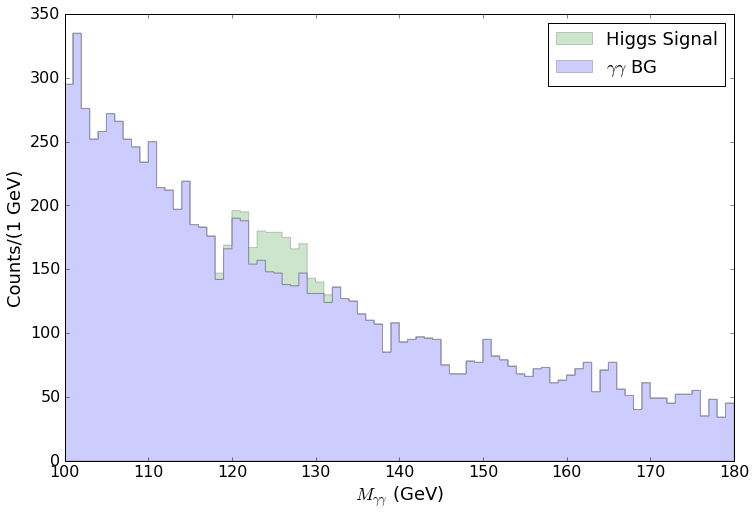

In [3]:
plt.hist([data_bg, data_sig], bins = 80, stacked=True, alpha=0.2, histtype='stepfilled', label=['$\gamma\gamma$ BG', 'Higgs Signal'])
plt.legend()
plt.ylabel('Counts/(1 GeV)')
plt.xlabel('$M_{\gamma\gamma}$ (GeV)')

Performing fit with initial parameters:
a1	= 0.000
a2	= 0.000
a3	= 0.000
Fit finished with status: 0
Calculating covariance of parameters...


RESULTS
-------
a1	= -0.957 +/- 0.016
a2	= 0.399 +/- 0.023
a3	= -0.126 +/- 0.024


CORRELATION MATRIX
------------------
[[ 1.    -0.455  0.133]
 [-0.455  1.    -0.448]
 [ 0.133 -0.448  1.   ]]




/Users/brianpollack/Coding/amumu/nllfitter/future_fitter.py:99: RuntimeWarning:

invalid value encountered in log



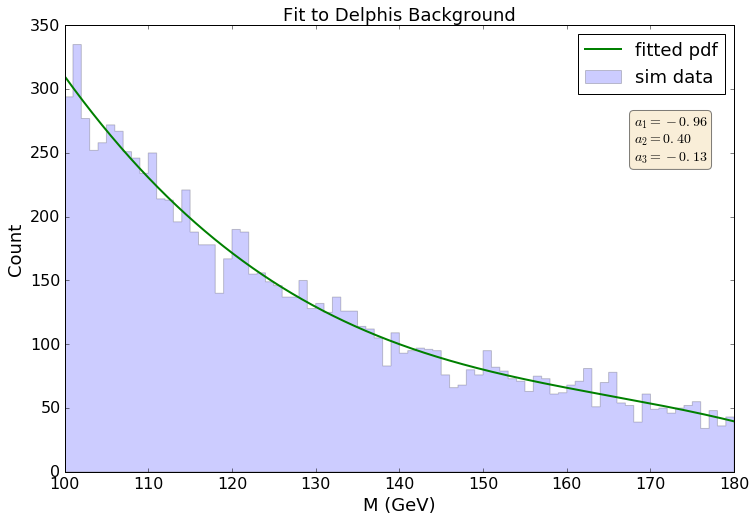

In [4]:
bg_model = ff.Model(hgg_tools.bg_pdf, ['a1', 'a2', 'a3'])
bg_model.set_bounds([(-1., 1.), (-1., 1.), (-1., 1.)])
bg_fitter = ff.NLLFitter(bg_model, data_bg)
bg_result = bg_fitter.fit([0.0, 0.0, 0.0])

textstr = ('$a_1={0:.2f}$\n$a_2={1:.2f}$\n$a_3={2:.2f}$').format(*bg_result.x)
make_fit_plot(data_bg, 80, xlimits, functools.partial(hgg_tools.bg_pdf, a=bg_result.x),
        'Fit to Delphis Background', textstr = textstr)


Performing fit with initial parameters:
mu	= 120.000
sigma	= 2.000
Fit finished with status: 0
Calculating covariance of parameters...


RESULTS
-------
mu	= 125.772 +/- 0.181
sigma	= 2.775 +/- 0.128


CORRELATION MATRIX
------------------
[[  1.000e+00  -2.531e-05]
 [ -2.531e-05   1.000e+00]]




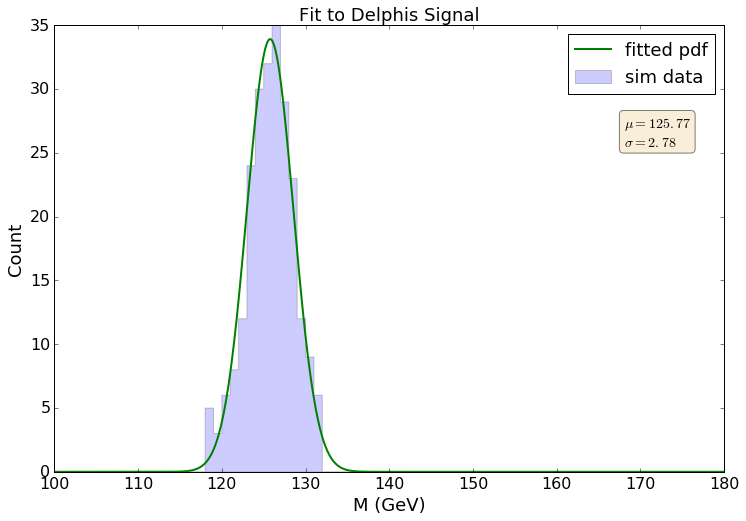

In [5]:
sig_model = ff.Model(hgg_tools.sig_pdf, ['mu', 'sigma'])
sig_model.set_bounds([(110, 130), (1, 5)])
sig_fitter = ff.NLLFitter(sig_model, data_sig)
sig_result = sig_fitter.fit([120.0, 2])

textstr = ('$\mu={0:.2f}$\n$\sigma={1:.2f}$').format(*sig_result.x)
make_fit_plot(data_sig, 80, xlimits, functools.partial(hgg_tools.sig_pdf, a=sig_result.x),
        'Fit to Delphis Signal', textstr = textstr)

## Generating MC from PDFs

We will use the functional forms defined above to create MC toys using the ROOT pdf sampling methods.  We are going to generate the same number of background and signal events as defined above, and then combine them together into a single dataset.  We can then fit that dataset with the combined background and signal pdfs, and extract a p-value and Gaussian Z-score based on the profile likelihood ratio.

In [7]:
from ROOT import gRandom
from ROOT import TF1

gRandom.SetSeed(111)

# Set up bg sampling
bg_pdf_ROOT = functools.partial(hgg_tools.bg_pdf, doROOT=True)
tf1_bg_pdf = TF1("tf1_bg_pdf", bg_pdf_ROOT, 100, 180, 3)
tf1_bg_pdf.SetParameters(*bg_result.x)
mc_bg = [tf1_bg_pdf.GetRandom() for i in xrange(len(data_bg))]

# Set up signal sampling
sig_pdf_ROOT = functools.partial(hgg_tools.sig_pdf, doROOT=True)
tf1_sig_pdf = TF1("tf1_sig_pdf", sig_pdf_ROOT, 100, 180, 2)
tf1_sig_pdf.SetParameters(*sig_result.x)
mc_sig = [tf1_sig_pdf.GetRandom() for i in xrange(len(data_sig))]

print 'number of bg events:',len(mc_bg)
print 'number of sig events:', len(mc_sig)

mc_bg_sig = mc_bg+mc_sig

number of bg events: 10000
number of sig events: 236


Now we will fit these distributions with the functional forms used to generate them.  We will fit with a background-only pdf and a background+signal pdf.  The ratio of the likelihood produced by these two methods will be used to calculate the significance.

Performing fit with initial parameters:
a1	= 0.000
a2	= 0.000
a3	= 0.000
Fit finished with status: 0
Calculating covariance of parameters...


RESULTS
-------
a1	= -0.963 +/- 0.016
a2	= 0.366 +/- 0.023
a3	= -0.091 +/- 0.024


CORRELATION MATRIX
------------------
[[ 1.    -0.463  0.147]
 [-0.463  1.    -0.462]
 [ 0.147 -0.462  1.   ]]




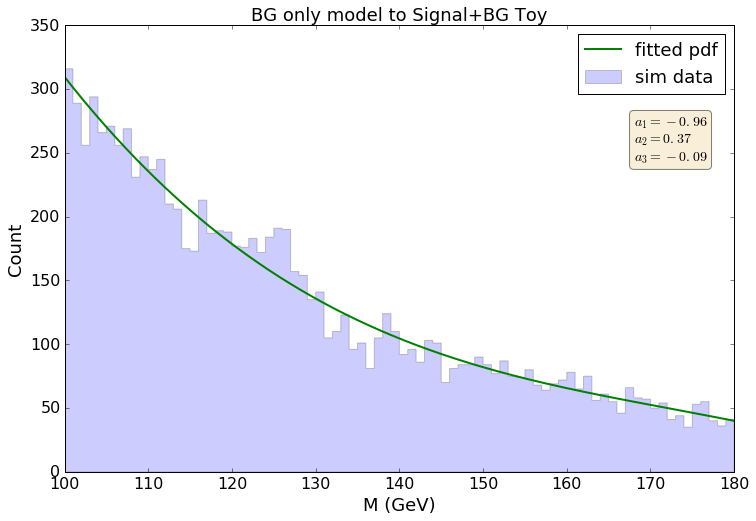

In [8]:
mc_bg_only_fitter = ff.NLLFitter(bg_model, np.asarray(mc_bg_sig))
mc_bg_only_result = mc_bg_only_fitter.fit([ 0.0, 0.0, 0.0])

textstr = ('$a_1={0:.2f}$\n$a_2={1:.2f}$\n$a_3={2:.2f}$').format(*mc_bg_only_result.x)
make_fit_plot(mc_bg_sig, 80, xlimits, functools.partial(hgg_tools.bg_pdf, a=mc_bg_only_result.x),
    'BG only model to Signal+BG Toy', textstr = textstr)

Performing fit with initial parameters:
C	= 0.010
mu	= 125.000
sigma	= 2.000
a1	= 0.000
a2	= 0.000
a3	= 0.000
Fit finished with status: 0
Calculating covariance of parameters...


RESULTS
-------
C	= 0.027 +/- 0.007
mu	= 125.338 +/- 0.619
sigma	= 2.636 +/- 0.638
a1	= -0.958 +/- 0.016
a2	= 0.414 +/- 0.026
a3	= -0.162 +/- 0.029


CORRELATION MATRIX
------------------
[[ 1.    -0.375  0.69   0.109  0.392 -0.537]
 [-0.375  1.    -0.504 -0.113 -0.055  0.168]
 [ 0.69  -0.504  1.     0.099  0.253 -0.369]
 [ 0.109 -0.113  0.099  1.    -0.376  0.041]
 [ 0.392 -0.055  0.253 -0.376  1.    -0.586]
 [-0.537  0.168 -0.369  0.041 -0.586  1.   ]]




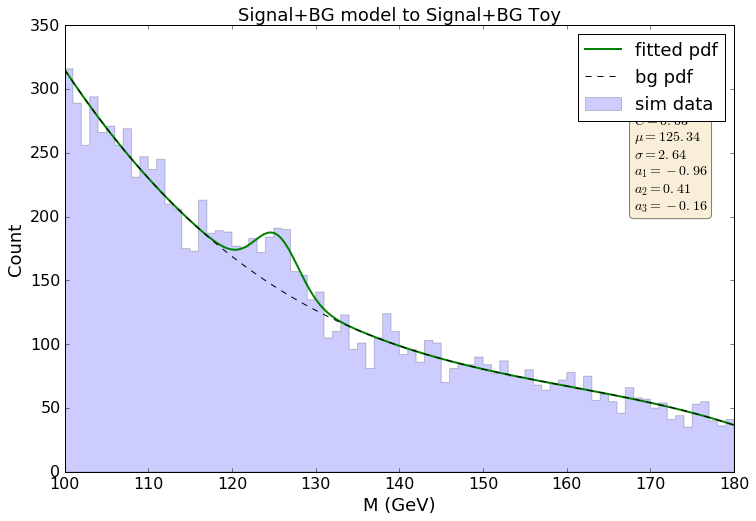

In [9]:
bg_sig_model = ff.Model(hgg_tools.bg_sig_pdf, ['C', 'mu', 'sigma', 'a1', 'a2', 'a3'])
bg_sig_model.set_bounds([(0, 1), (xlimits[0], xlimits[1]), (0, 50), (-1., 1.), (-1., 1.), (-1., 1.)])
mc_bg_sig_fitter = ff.NLLFitter(bg_sig_model, np.asarray(mc_bg_sig))
mc_bg_sig_result = mc_bg_sig_fitter.fit([0.01, 125.0, 2, 0.0, 0.0, 0.0])

textstr = ('$C={0:.2f}$\n$\mu={1:.2f}$\n$\sigma={2:.2f}$\n'
          '$a_1={3:.2f}$\n$a_2={4:.2f}$\n$a_3={5:.2f}$').format(*mc_bg_sig_result.x)
make_fit_plot(mc_bg_sig, 80, xlimits, functools.partial(hgg_tools.bg_sig_pdf, a=mc_bg_sig_result.x),
    'Signal+BG model to Signal+BG Toy', extra_pdf_tuple=(functools.partial(hgg_tools.bg_sig_pdf,
    a=np.concatenate([[0], mc_bg_sig_result.x[1:]])), 1-mc_bg_sig_result.x[0], 'bg pdf'), textstr = textstr)


Now that we have fit the distribution with both a bg-only and a bg+signal pdf, we can compare the two likelihoods in the following way:
$$\lambda(\mu)=\frac{L(\mu,\hat{\hat{\boldsymbol{\theta}}})}{L(\hat{\mu},\hat{\boldsymbol{\theta}})}$$
where $\mu=0$ (representing the background-only hypothesis), and $\hat{\mu}$ is a free parameter, determined by the fitting procedure.  We can then use then construct the test statistic $q_0$ for discovering a new signal:
$$q_0 = \left\{ \begin{array}{ll} -2\ln\lambda(0) & \quad \hat{\mu} \geq 0, \\ 0 & \quad \hat{\mu} <0 \end{array} \right.$$
Assuming the Wald approximation holds (https://arxiv.org/abs/1007.1727), the pdf of $q_0$ for a given $\mu$ can be represented by a $\frac{1}{2}\chi^2$ distribution of 1 degree of freedom, and the CDF of that distribution is:
$$F(q_0|\mu=0)=\Phi(\sqrt{q_0})$$
The Guassian significance is:
$$Z_0 = \sqrt{q_0} $$

In [10]:
from IPython.display import HTML
nll_bg  = mc_bg_only_result.fun
nll_sig = mc_bg_sig_result.fun
q0= 2*max(nll_bg-nll_sig,0)
HTML('<h3><b>Significance of peak from nll fit: {0:.3f} sigma</b></h3>'.format(np.sqrt(q0)))

## Using Bayesian Blocks Binning to Discover Signals

Looking at the plots above, it is not obvious by eye that there is signal injected into the distribution.  We will attempt to use BB binning to both:
  1. Assist in visualizing important data features.
  2. Extract statistical information from the data, using only the histogram content.
  
In order to do so, we will first construct a series of bin edges that represent both the background and the data.

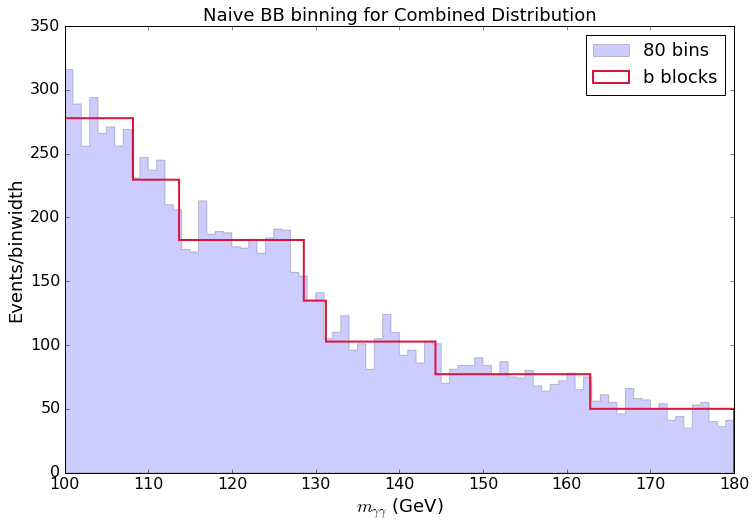

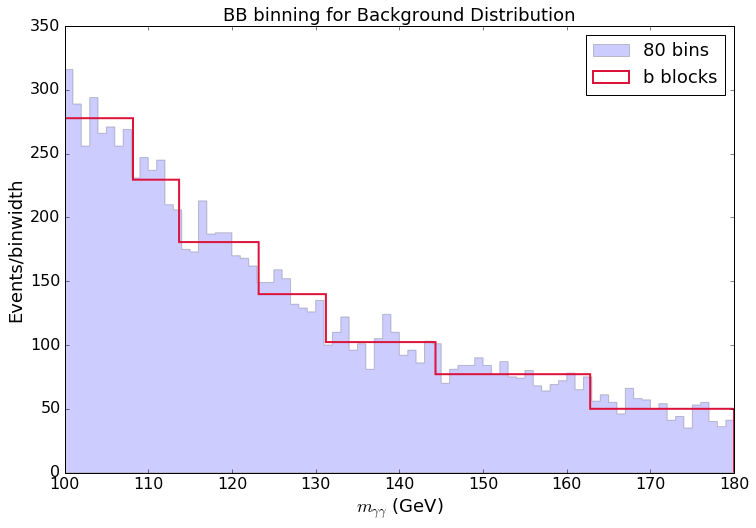

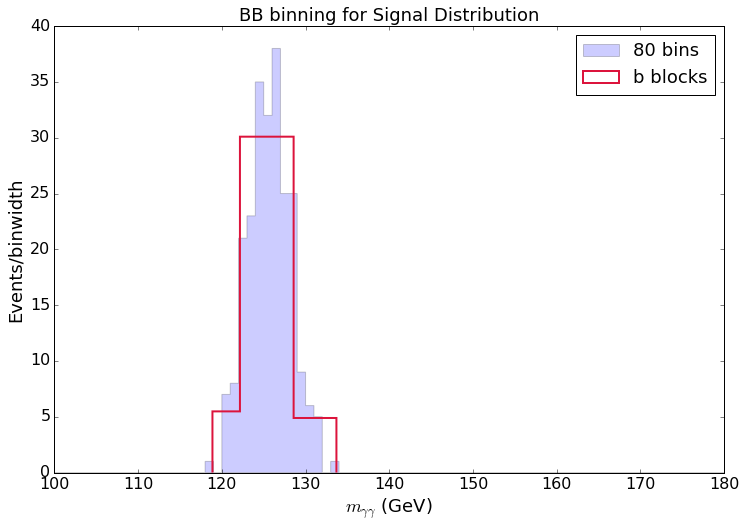

In [11]:
import warnings
warnings.filterwarnings("ignore")

_, _ = make_bb_plot(mc_bg_sig, 0.02, bb_dir+'/plots/', range=xlimits, scale='binwidth',
                title='Naive BB binning for Combined Distribution',
               xlabel=r'$m_{\gamma\gamma}$ (GeV)', ylabel='Events/binwidth', save_name='hgg_bg_hist')

bc_bg, be_bg = make_bb_plot(mc_bg, 0.02, bb_dir+'/plots/', range=xlimits, scale='binwidth',
                title='BB binning for Background Distribution',
               xlabel=r'$m_{\gamma\gamma}$ (GeV)', ylabel='Events/binwidth', save_name='hgg_bg_hist')
bc_sig, be_sig = make_bb_plot(mc_sig, 0.02, bb_dir+'/plots/', range=xlimits, scale='binwidth',
                title='BB binning for Signal Distribution',
                 xlabel=r'$m_{\gamma\gamma}$ (GeV)', ylabel='Events/binwidth', save_name='hgg_sig_hist')


We will now combine the bin edges for the background and signal.  We will exclude the background bins that occur within the signal bins, so that the signal region is binned solely by the BB distribution trained on the signal.  We will then use this binning to view the background-only MC and the background+signal MC.

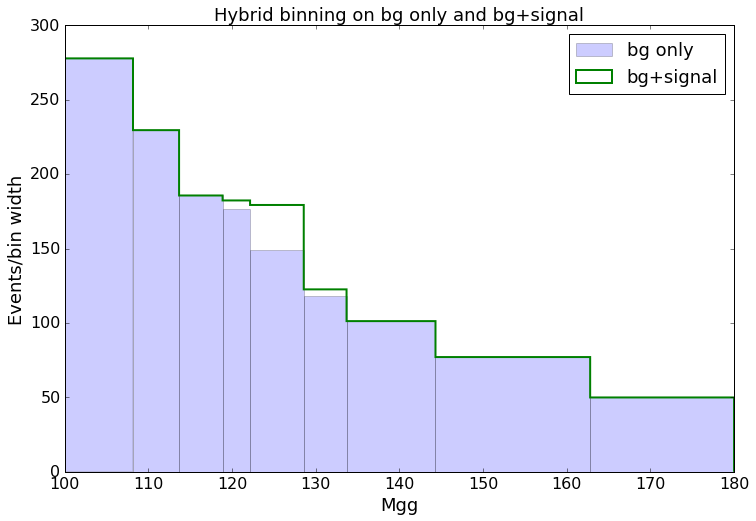

In [12]:
be_hybrid = np.concatenate([be_bg[be_bg<be_sig[0]], be_sig, be_bg[be_bg>be_sig[-1]]])
bc_bg, _, _ = hist(mc_bg,be_hybrid,alpha=0.2,scale='binwidth', label='bg only')
bc_bg_sig, _, _ = hist(mc_bg_sig,be_hybrid,scale='binwidth', histtype='step', linewidth = 2, label='bg+signal')
plt.title('Hybrid binning on bg only and bg+signal')
plt.xlabel('Mgg')
plt.ylabel('Events/bin width')
plt.legend()
plt.show()

There is an obvious signal excess here, which is not apparent when using uniform binning.  The fairly uniform decrease in step height is modified by the presence of signal.  We can use the main signal bin (or all bins, in principle) to calculate a likelihood ratio, and thus a significance for the signal.

In [13]:
import scipy.integrate as integrate
from scipy.stats import poisson
# Get the bg and bg+sig counts from the above binning
counts_bg, _ = np.histogram(mc_bg,be_hybrid)
counts_bg_sig, _ = np.histogram(mc_bg_sig,be_hybrid)
# Get the true number of background events by integrating the bg pdf in the bin of interest,
# and multiplying that by the number of generated bg events
true_bg, _  = integrate.quad(functools.partial(hgg_tools.bg_pdf, a=bg_result.x),be_hybrid[4],be_hybrid[5])
true_bg     = true_bg*len(mc_bg)
# Do the same for the true number of signal events
true_sig, _  = integrate.quad(functools.partial(hgg_tools.sig_pdf, a=sig_result.x),be_hybrid[4],be_hybrid[5])
true_sig     = true_sig*len(mc_sig)

ndata = counts_bg_sig[4]
print ndata, true_bg+true_sig
nll_bg_bin = -np.log(poisson.pmf(ndata,true_bg))
nll_sig_bin = -np.log(poisson.pmf(ndata,true_bg+true_sig))
q0_bb = np.sqrt(2*(nll_bg_bin-nll_sig_bin))
HTML('<h3><b>Significance of single bin from bb: {0:.3f} sigma</b></h3>'.format(q0_bb))

1150 1121.25910922


We should also calculate the significance given the likelihood of all bins in our range:

In [14]:
l_bg = 1
l_sig = 1
for i in range(len(be_hybrid)-1):
    true_bg, _   = integrate.quad(functools.partial(hgg_tools.bg_pdf, a=bg_result.x),be_hybrid[i],be_hybrid[i+1])
    true_bg      = true_bg*len(mc_bg)
    true_sig, _  = integrate.quad(functools.partial(hgg_tools.sig_pdf, a=sig_result.x),be_hybrid[i],be_hybrid[i+1])
    true_sig     = true_sig*len(mc_sig)

    ndata = counts_bg_sig[i]
    l_bg  *= poisson.pmf(ndata,true_bg)
    l_sig *= poisson.pmf(ndata,true_bg+true_sig)
    
q0_bb_full = np.sqrt(-2*(np.log(l_bg)-np.log(l_sig)))
HTML('<h3><b>Significance of all bins from bb: {0:.3f} sigma</b></h3>'.format(q0_bb_full))

This seems to imply that the significance extracted from the Bayesian Block binning scheme is higher than that of the unbinned fit.  This is unexpected, to say the least, and will obviously require more scrutiny.  Assuming the calculation is correct, it could be that because the BB method is not directly taking into account the nuisance parameters that are inherent in the unbinned fit, the significance is enhanced.

## Running Many Toys

In the following comparison, we will repeat the previous studies for many toys, then compare the average significance for both the nll fit and bayesian block methods.

In [15]:
%run hgg_comp.py

Performing fit with initial parameters:
a1	= 0.000
a2	= 0.000
a3	= 0.000
Fit finished with status: 0
Calculating covariance of parameters...



100%|██████████| 500/500 [02:05<00:00,  3.92it/s]


RESULTS
-------
a1	= -0.957 +/- 0.016
a2	= 0.399 +/- 0.023
a3	= -0.126 +/- 0.024


CORRELATION MATRIX
------------------
[[ 1.    -0.455  0.133]
 [-0.455  1.    -0.448]
 [ 0.133 -0.448  1.   ]]


Performing fit with initial parameters:
mu	= 120.000
sigma	= 2.000
Fit finished with status: 0
Calculating covariance of parameters...


RESULTS
-------
mu	= 125.772 +/- 0.181
sigma	= 2.775 +/- 0.128


CORRELATION MATRIX
------------------
[[  1.000e+00  -2.531e-05]
 [ -2.531e-05   1.000e+00]]




In [18]:
binned_model.components

[<lmfit.Model: Model(lm_binned)>]


variable "binned_model" not defined.

variable "binned_model." not defined.


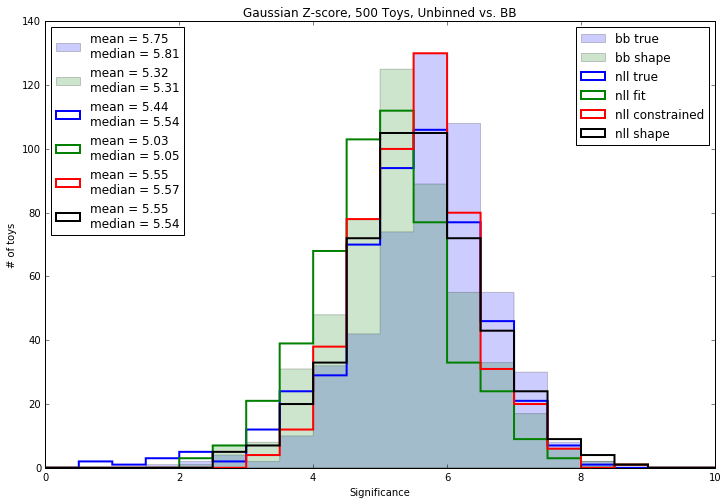

In [5]:
_,_,pt = hist(signif_bb_true_hist,20, range=(0,10), alpha=0.2, histtype='stepfilled', label='bb true')
_,_,ps = hist(signif_bb_shape_hist,20, range=(0,10), alpha=0.2, histtype='stepfilled', label='bb shape')
hist(signif_nll_true_hist,20, linewidth=2, range=(0,10), histtype='step',color=pt[0].get_facecolor()[:-1], label='nll true')
hist(signif_nll_fit_hist,20, range=(0,10), linewidth=2, histtype='step', color=ps[0].get_facecolor()[:-1], label='nll fit')
hist(signif_nll_constrained_hist,20, range=(0,10), linewidth=2, histtype='step', label='nll constrained')
hist(signif_nll_true_fit_hist,20, range=(0,10), linewidth=2, color='k', histtype='step', label='nll shape')


plt.title('Gaussian Z-score, 500 Toys, Unbinned vs. BB')
plt.xlabel('Z Score')
plt.ylabel('# of toys')
le = plt.legend(loc=1)
plt.gca().add_artist(le)
handles, labels = plt.gca().get_legend_handles_labels()
labels = []
labels.append('mean = {0:.2f}\nmedian = {1:.2f}'.format(np.mean(signif_bb_true_hist),np.median(signif_bb_true_hist)))
labels.append('mean = {0:.2f}\nmedian = {1:.2f}'.format(np.mean(signif_bb_shape_hist),np.median(signif_bb_shape_hist)))
labels.append('mean = {0:.2f}\nmedian = {1:.2f}'.format(np.mean(signif_nll_true_hist),np.median(signif_nll_true_hist)))
labels.append('mean = {0:.2f}\nmedian = {1:.2f}'.format(np.mean(signif_nll_fit_hist),np.median(signif_nll_fit_hist)))
labels.append('mean = {0:.2f}\nmedian = {1:.2f}'.format(np.mean(signif_nll_constrained_hist),np.median(signif_nll_constrained_hist)))
labels.append('mean = {0:.2f}\nmedian = {1:.2f}'.format(np.mean(signif_nll_true_fit_hist),np.median(signif_nll_true_fit_hist)))



plt.legend(handles,labels,loc=2)

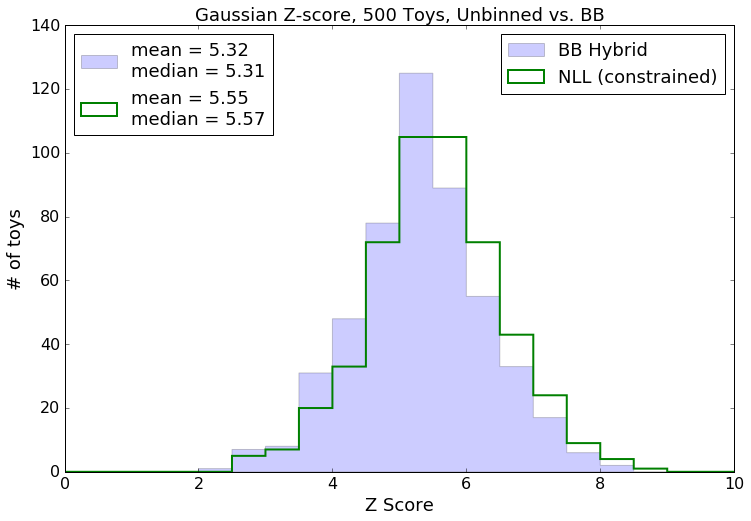

In [16]:
_,_,ps = hist(signif_bb_shape_hist,20, range=(0,10), alpha=0.2, histtype='stepfilled', label='BB Hybrid')
hist(signif_nll_true_fit_hist,20, range=(0,10), linewidth=2, histtype='step', label='NLL (constrained)')


plt.title('Gaussian Z-score, 500 Toys, Unbinned vs. BB')
plt.xlabel('Z Score')
plt.ylabel('# of toys')
le = plt.legend(loc=1)
plt.gca().add_artist(le)
handles, labels = plt.gca().get_legend_handles_labels()
labels = []
labels.append('mean = {0:.2f}\nmedian = {1:.2f}'.format(np.mean(signif_bb_shape_hist),np.median(signif_bb_shape_hist)))
labels.append('mean = {0:.2f}\nmedian = {1:.2f}'.format(np.mean(signif_nll_constrained_hist),np.median(signif_nll_constrained_hist)))



plt.legend(handles,labels,loc=2)

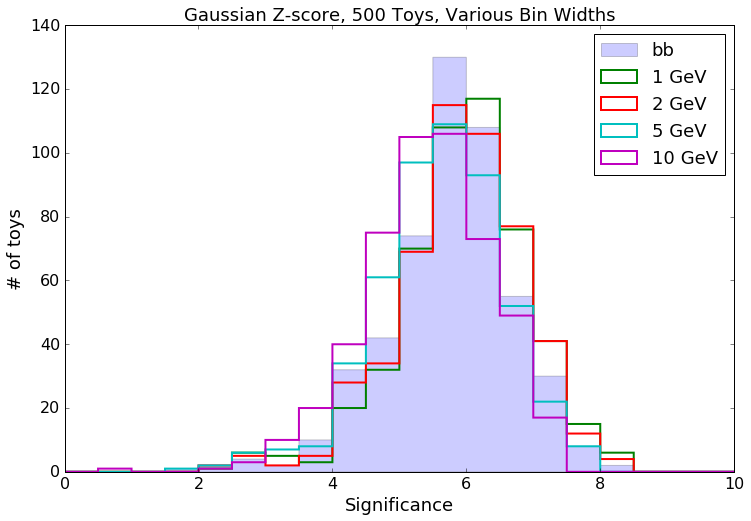

In [17]:
hist(signif_bb_true_hist,20, range=(0,10), alpha=0.2, histtype='stepfilled', label='bb')
hist(signif_1GeV_true_hist,20, range=(0,10), linewidth=2, histtype='step', label='1 GeV')
hist(signif_2GeV_true_hist,20, range=(0,10), linewidth=2, histtype='step', label='2 GeV')
hist(signif_5GeV_true_hist,20, range=(0,10), linewidth=2, histtype='step', label='5 GeV')
hist(signif_10GeV_true_hist,20, range=(0,10), linewidth=2, histtype='step', label='10 GeV')
plt.title('Gaussian Z-score, 500 Toys, Various Bin Widths')
plt.xlabel('Significance')
plt.ylabel('# of toys')
plt.legend()

In [ ]:
be_hybrid = np.concatenate([be_bg[be_bg<be_sig[0]], be_sig, be_bg[be_bg>be_sig[-1]]])
bc_bg, _, _ = hist(mc_bg,be_hybrid,alpha=0.2,scale='binwidth', label='bg only')
bc_bg_sig, _, _ = hist(mc_bg_sig,be_hybrid,scale='binwidth', histtype='step', linewidth = 2, label='bg+signal')
plt.title('Hybrid binning on bg only and bg+signal')
plt.xlabel('Mgg')
plt.ylabel('Events/bin width')
plt.legend()
plt.show()